<div style="width:100%;height:6px;background-color:green"> </div>

#### Tasks:

<b>T3.1</b>  Try PCA on your own image for the detection of uncorrelated anomalies in the image (or noise).<b style="color:blue;">[0.3 Points]</b>

<b>T3.2</b>  Explore the influence of the choice of the number of eigenvectors on the quality of detection.<b style="color:blue;">[0.3 Points]</b>

<b>T3.3</b>  Create concise documentation for the solution, code, and the achieved results (3-5 pages of A4). Properly cite the used sources!<b style="color:blue;">[0.6 Points]</b>

<br>


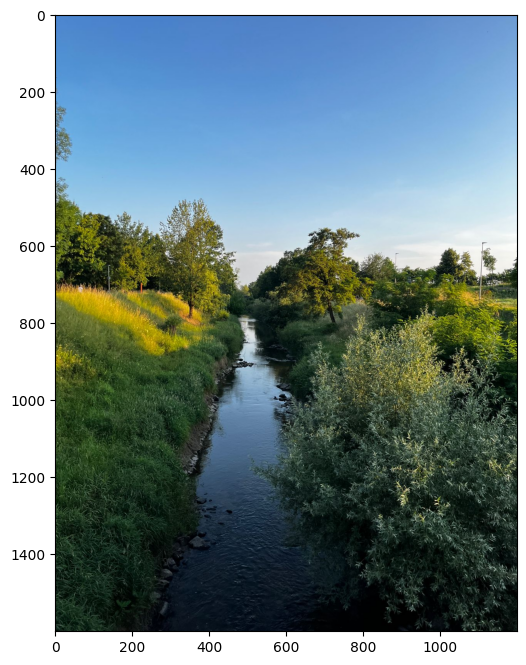

Image size (width, height): (1200, 1600)
Image mode (color channels): RGB


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL as pil
img1=r"D:\USB\Second Sem\Feature Engineering\Assignment-3\img\River.jpg"


im1 = pil.Image.open(img1)


plt.figure(figsize=(8,8)) 
plt.imshow(im1)
plt.show()

print("Image size (width, height):", im1.size)
print("Image mode (color channels):", im1.mode)

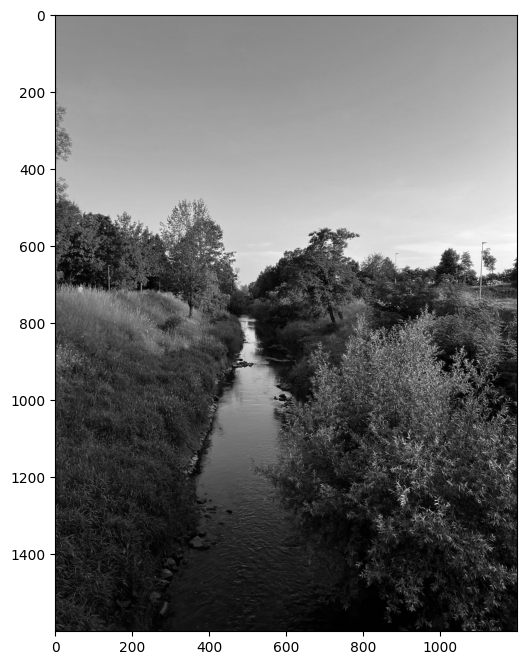

im1 is now matrix, i.e. <class 'numpy.ndarray'> (1600, 1200)


In [3]:
from scipy import signal
im1=np.mean(im1,2)  # gray img, 2-D matrix,...X

plt.figure(figsize=(8,8)) 
plt.imshow(im1,cmap='gray')
plt.show()

print("im1 is now matrix, i.e.", type(im1), im1.shape)

In [4]:
# Normalising the features

X = im1.copy()
X = (X - np.mean(X))/np.std(X)

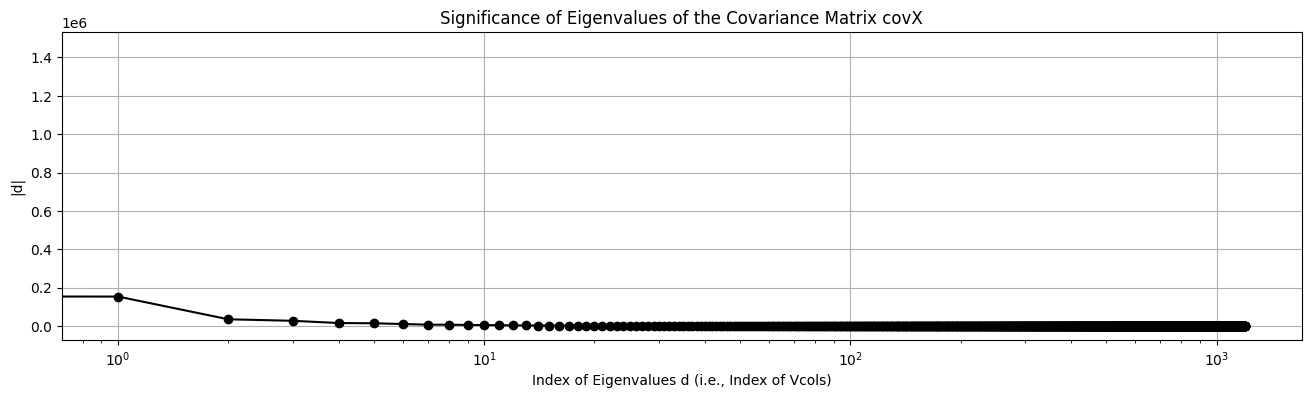

In [5]:
# Localization of uncorrelated events:

covX = np.dot(X.T, X)  # Covariance matrix (M x M)

d, Vcols = np.linalg.eig(covX)  # Eigenvalues and eigenvectors

plt.figure(figsize=(16, 4))
plt.title("Significance of Eigenvalues of the Covariance Matrix covX")
plt.semilogx(abs(d), '-ok')
plt.ylabel('|d|')
plt.xlabel('Index of Eigenvalues d (i.e., Index of Vcols)')
plt.grid()
plt.show()

In [6]:
idx = np.argsort(d)[::-1]
eigvals_cols = d[idx]
eigvecs_cols = Vcols[:, idx]

m = 6  # number of top column eigenvectors
X_cols_compressed = np.dot(X, eigvecs_cols[:, :m])

# Row-wise PCA
X_rows = X_cols_compressed.T
cov_rows = np.dot(X_rows.T, X_rows)
eigvals_rows, eigvecs_rows = np.linalg.eig(cov_rows)
idx_r = np.argsort(eigvals_rows)[::-1]
eigvals_rows = eigvals_rows[idx_r]
eigvecs_rows = eigvecs_rows[:, idx_r]

n = 6  # number of top row eigenvectors
X_compressed = np.dot(X_rows, eigvecs_rows[:, :n])

In [7]:
# Reconstruct image from compressed representation
X_recon_rows = np.dot(X_compressed, eigvecs_rows[:, :n].T)
X_recon_cols = X_recon_rows.T
X_pca = np.dot(X_recon_cols, eigvecs_cols[:, :m].T)
X_pca = np.real(X_pca)

C:\Users\Tushar Garg\AppData\Local\Temp\ipykernel_39612\944996814.py:2: RuntimeWarning: invalid value encountered in power
  residual = (X_pca - X) ** 1.5  # exaggerate differences


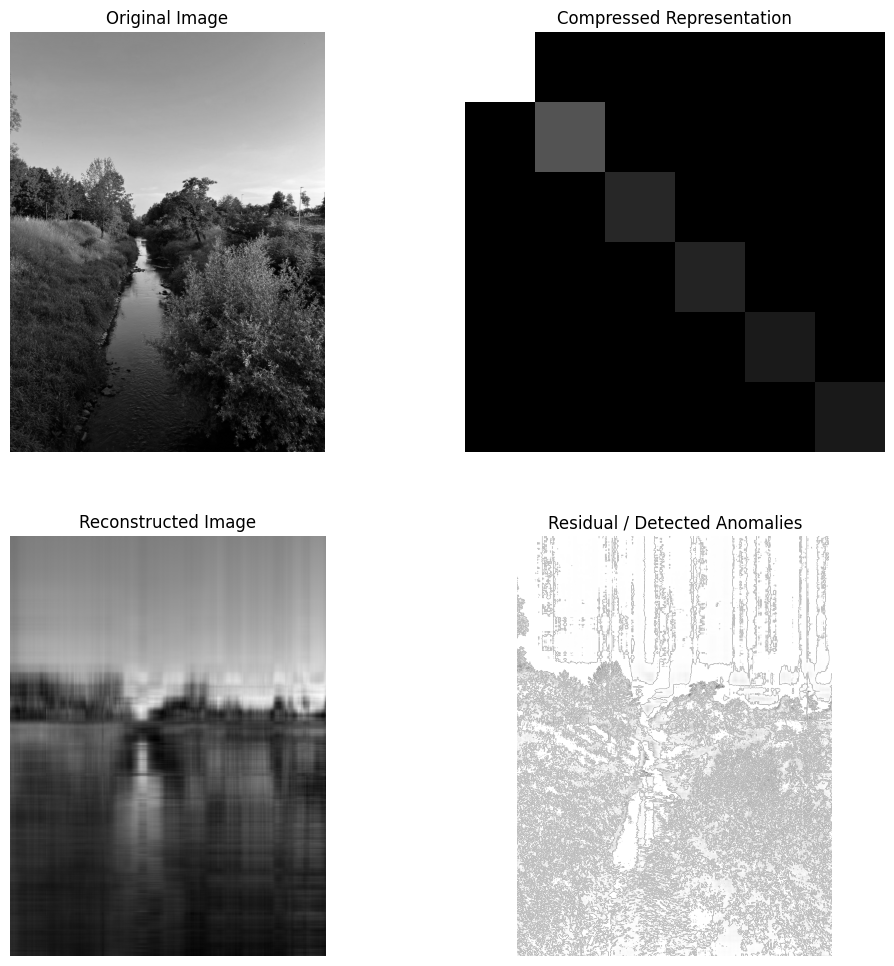

(1600, 1200)


In [8]:
# Residual map for anomaly detection
residual = (X_pca - X) ** 1.5  # exaggerate differences

plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.imshow(X, cmap='gray'); plt.title("Original Image"); plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(abs(X_compressed), cmap='gray'); plt.title("Compressed Representation"); plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(X_pca, cmap='gray'); plt.title("Reconstructed Image"); plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(-residual, cmap='gray'); plt.title("Residual / Detected Anomalies"); plt.axis('off')
plt.show()

print(X_pca.shape)

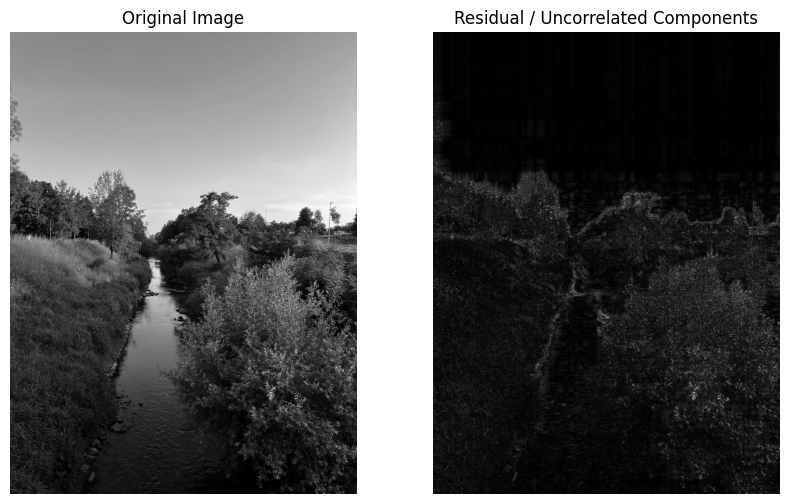

In [9]:
m = 6  # number of dominant components to exclude
Vcols_residual = eigvecs_cols[:, m:]  # residual columns

X_cols_residual = np.dot(X, Vcols_residual)
X_rows = X_cols_residual.T
cov_rows = np.dot(X_rows.T, X_rows)
eigvals_rows, eigvecs_rows = np.linalg.eig(cov_rows)

# Sort eigenvectors
idx_rows = np.argsort(eigvals_rows)[::-1]
eigvecs_rows = eigvecs_rows[:, idx_rows]

n = 6  # number of dominant row components to exclude
Vrows_residual = eigvecs_rows[:, n:]  # residual rows

X_residual_compressed = np.dot(X_rows, Vrows_residual)
X_residual_rows = np.dot(X_residual_compressed, Vrows_residual.T)
X_residual_cols = X_residual_rows.T
X_residual = np.dot(X_residual_cols, Vcols_residual.T)
X_residual = np.real(X_residual)

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.imshow(X, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.abs(X_residual), cmap='gray')
plt.title("Residual / Uncorrelated Components")
plt.axis('off')
plt.show()

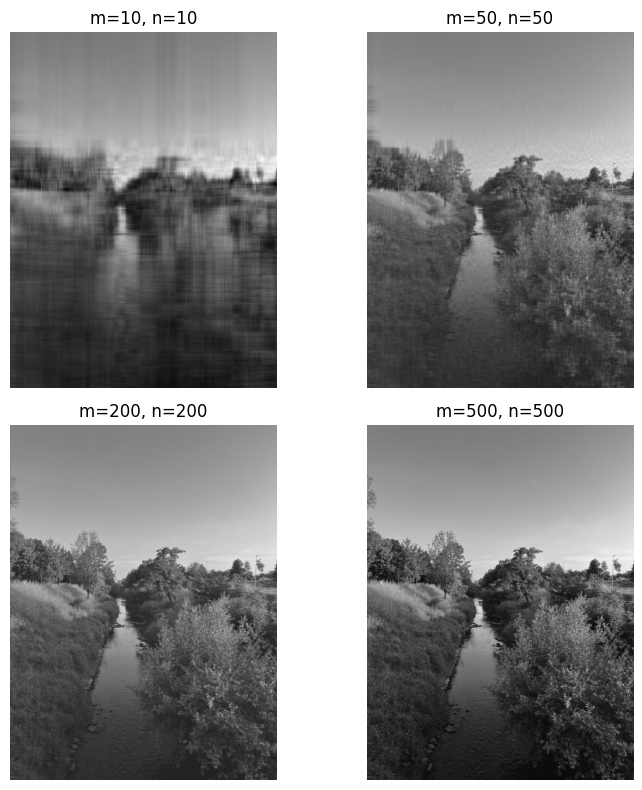

In [27]:
m_values = [(10, 10), (50, 50), (200, 200), (500, 500)]    # top column eigenvectors
plt.figure(figsize=(8, 8))

for i, (m, n) in enumerate(m_values, 1):
    Vcols_keep = eigvecs_cols[:, :m]
    X_cols_proj = X @ Vcols_keep

    # Row-wise PCA on top column components
    X_rows = X_cols_proj.T
    cov_rows = X_rows.T @ X_rows
    eigvals_rows, eigvecs_rows = np.linalg.eig(cov_rows)
    idx_rows = np.argsort(eigvals_rows)[::-1]
    eigvecs_rows = eigvecs_rows[:, idx_rows]
    Vrows_keep = eigvecs_rows[:, :n]

    # Compress and reconstruct
    X_compressed = X_rows @ Vrows_keep
    X_recon_rows = X_compressed @ Vrows_keep.T
    X_recon_cols = X_recon_rows.T
    X_pca = X_recon_cols @ Vcols_keep.T
    X_pca = np.real(X_pca)

    # Plot reconstructed image
    plt.subplot(2, 2, i)  # 2 rows, 2 columns, position i
    plt.imshow(X_pca, cmap='gray')
    plt.title(f"m={m}, n={n}")
    plt.axis('off')

plt.tight_layout()
plt.show()